## ID: 0710018
## Name: 張宸愷

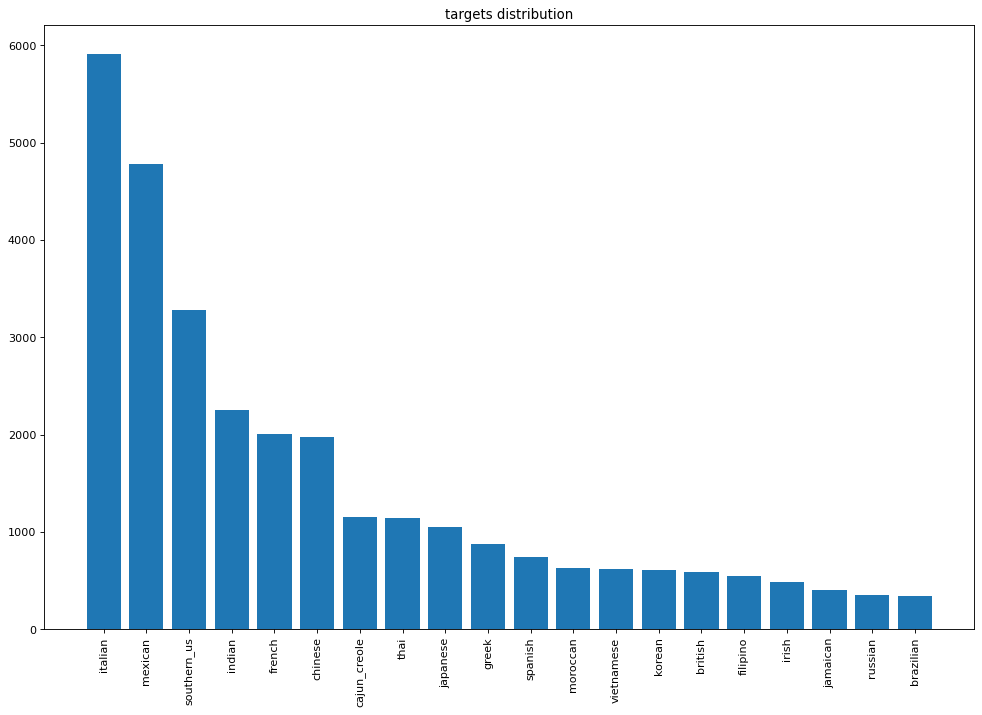

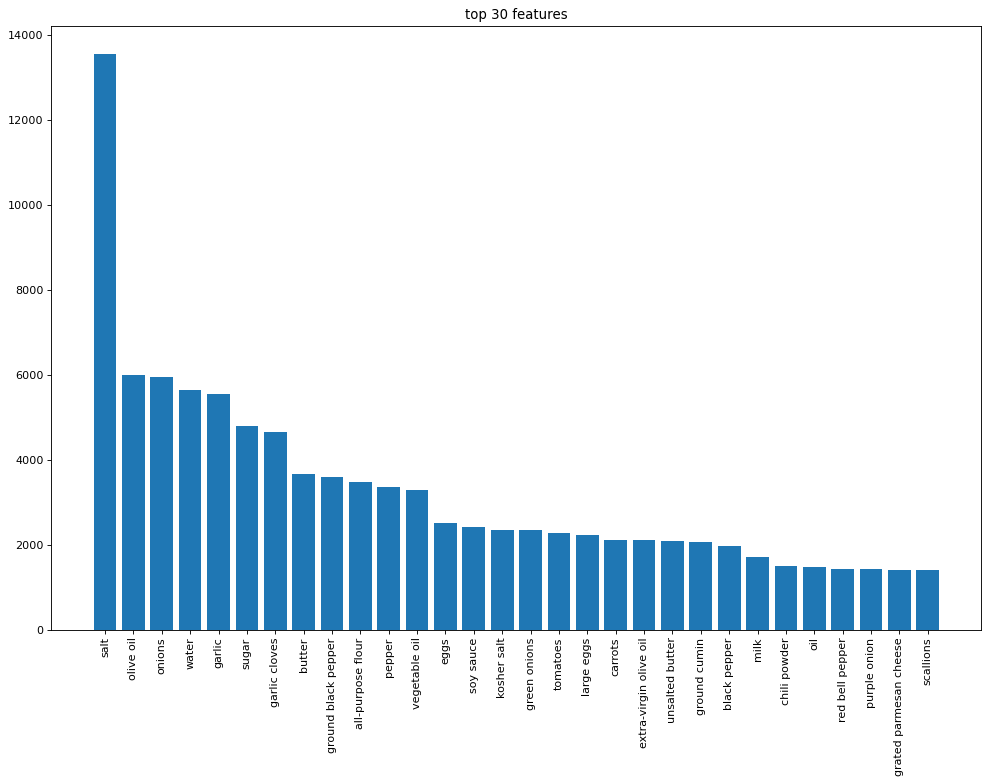

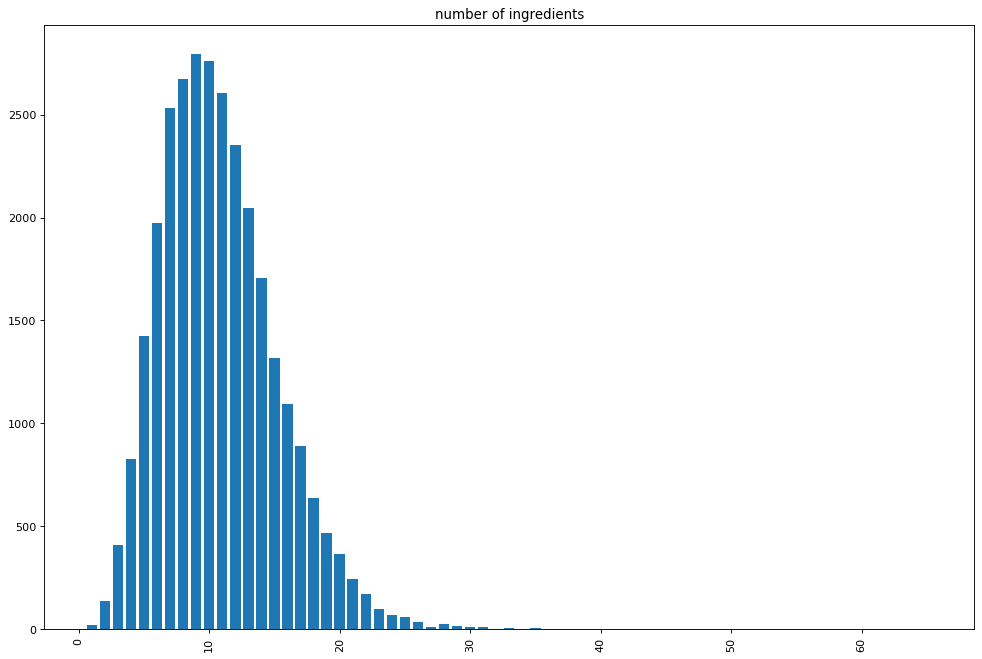

In [9]:
# Data visualization

from matplotlib import pyplot as plt
import pandas as pd

df = pd.read_json("train.json")


# print(df)

# show label distributions
catos = df["cuisine"].value_counts()
f = plt.figure(figsize=(15, 10), dpi=80)
plt.bar(catos.index, catos.values)
_ = plt.xticks(rotation="vertical")
plt.title("targets distribution")

# show top 30 features
ing = df["ingredients"]
a = []
for i in ing:
    a += i
cc = pd.Series(a)
top_30 = cc.value_counts().head(30)
f = plt.figure(figsize=(15, 10), dpi=80)
_ = plt.bar(top_30.index, top_30.values)
_ = plt.title("top 30 features")
_ = plt.xticks(rotation="vertical")


# show feature lengths

c = []
for i in ing:
    c.append(len(i))
cc = pd.Series(c)
# print(cc.value_counts())
cc = cc.value_counts()

f = plt.figure(figsize=(15, 10), dpi=80)
_ = plt.bar(cc.index, cc.values)
_ = plt.title("number of ingredients")
_ = plt.xticks(rotation="vertical")


# Model selection
I use a model with two hidden layers. Between the hidden layers I also added dropout layers, to increase the robustness of the model. I use the cross entropy loss for the loss function. Training was done for 3 epochs using the Adam optimizer with learning rate 0.001. Futher training will result in overfitting of the model, as seen by the drop in validation accuracy.

In [10]:
# load data, preprocessing, and model construction

from scipy.sparse import data
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelBinarizer
import os
import shutil
import numpy as np
from sklearn.utils import shuffle

# save_path = "/kaggle/working/"
# input_path = "/kaggle/input/ml-hw5/"
# model_save_ = "/kaggle/input/notebook-ml-hw5/"
save_path = ""
input_path = ""
model_save_ = ""


training_set = pd.read_json(input_path + "train.json")
validation_set = pd.read_json(input_path + "test.json")

oh = LabelBinarizer()

mlb = MultiLabelBinarizer()
X_train: np.ndarray = mlb.fit_transform(training_set["ingredients"]) # one hot
y_train: np.ndarray = oh.fit_transform(
    np.array(training_set["cuisine"]).reshape(-1, 1)) # unsqueeze and one hot
X_train, y_train = shuffle(X_train, y_train) # data shuffle


class MLP:
    def __init__(self, input_shape, load_model=False) -> None:
        data_in = keras.Input(shape=(input_shape, ))
        x = data_in
        x = keras.layers.Dropout(0.2)(x)
        x = keras.layers.Dense(400, activation='relu')(x)
        x = keras.layers.Dropout(0.5)(x)
        x = keras.layers.Dense(100, activation='relu')(x)
        x = keras.layers.Dense(20, activation='softmax')(x)
        if os.path.exists(model_save_ + "my_model") and load_model:
            print("model exists!")
            self.model = keras.models.load_model(
                model_save_ + "my_model")  # load saved model
        else:
            self.model = keras.Model(
                inputs=data_in, outputs=x)  # construct model

    def train(self, X, y, epochs=3, val_split=0.1):
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                           loss=keras.losses.CategoricalCrossentropy(),
                           metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Precision()])  # compile model

        history = self.model.fit(
            X, y, batch_size=32, epochs=epochs, validation_split=val_split)  # change the validation split when we want to submit to the competition

    def forward(self, X):
        y = self.model.predict(X)
        return y




In [11]:
# evaluate results

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

m1 = MLP(X_train.shape[1], load_model=False)

tr_x, te_x, tr_y, te_y = train_test_split(X_train, y_train, train_size=0.7)
m1.train(tr_x, tr_y, 3, 0.0)
y_pred = m1.forward(te_x)
y_pred = oh.inverse_transform(y_pred)
te_y = oh.inverse_transform(te_y)

confm = confusion_matrix(te_y, y_pred, labels=oh.classes_)
df = pd.DataFrame(index=[x+" (true)" for x in oh.classes_],
                  columns=[x+" (pred)" for x in oh.classes_], data=confm)
display(df)
report = classification_report(
    te_y, y_pred, output_dict=True, labels=oh.classes_)

t = [[report["accuracy"], report[x]["recall"], report[x]["precision"]] for x in oh.classes_]

df = pd.DataFrame(index=oh.classes_, columns=["Accuracy", "Recall", "Precision"], data=t)
display(df)



Epoch 1/3
652/652 [==============================] - 42s 61ms/step - loss: 1.8265 - categorical_accuracy: 0.4759 - precision: 0.7867
Epoch 2/3
652/652 [==============================] - 38s 58ms/step - loss: 0.8545 - categorical_accuracy: 0.7443 - precision: 0.8577
Epoch 3/3
652/652 [==============================] - 45s 68ms/step - loss: 0.6976 - categorical_accuracy: 0.7903 - precision: 0.8794


,brazilian (pred),british (pred),cajun_creole (pred),chinese (pred),filipino (pred),french (pred),greek (pred),indian (pred),irish (pred),italian (pred),jamaican (pred),japanese (pred),korean (pred),mexican (pred),moroccan (pred),russian (pred),southern_us (pred),spanish (pred),thai (pred),vietnamese (pred)
brazilian (true),47,0,0,1,3,2,1,4,1,3,0,0,0,27,0,0,4,2,2,1
british (true),1,59,3,2,3,31,2,5,21,11,0,2,1,1,0,3,28,0,1,0
cajun_creole (true),0,0,259,1,1,19,1,0,0,14,2,0,1,11,0,1,37,2,0,0
chinese (true),0,1,2,504,1,3,0,3,0,3,0,15,6,3,1,0,3,0,17,6
filipino (true),1,1,0,19,106,4,0,2,0,3,2,3,3,7,0,0,7,3,12,8
french (true),0,4,9,2,0,404,6,4,5,105,1,5,0,6,3,2,33,9,1,1
greek (true),0,0,0,0,0,6,185,1,0,46,0,0,0,2,3,0,3,3,0,0
indian (true),0,0,1,4,3,2,2,621,0,12,3,7,0,9,10,0,2,1,8,1
irish (true),0,17,0,0,0,24,3,1,67,10,2,0,0,3,0,0,26,1,0,0
italian (true),0,1,11,2,0,124,40,4,4,1527,0,1,0,19,2,0,34,3,0,0


,Accuracy,Recall,Precision
brazilian,0.778686,0.479592,0.770492
british,0.778686,0.339080,0.641304
cajun_creole,0.778686,0.742120,0.755102
chinese,0.778686,0.887324,0.754491
filipino,0.778686,0.585635,0.751773
french,0.778686,0.673333,0.546685
greek,0.778686,0.742972,0.675182
indian,0.778686,0.905248,0.858921
irish,0.778686,0.435065,0.587719
italian,0.778686,0.861738,0.811802


In [12]:
# train to submit to kaggle
m2 = MLP(X_train.shape[1], load_model=False)
m2.train(X_train, y_train, val_split=0.0)
# m2.model.save(save_path + "my_model")  # save weights
X_test = mlb.transform(validation_set["ingredients"])

y_pred = m2.forward(X_test)  # inference
y_pred = oh.inverse_transform(y_pred, threshold=0.5)  # get back labels

# construct submission csv
ss = pd.Series(y_pred.squeeze())
outp = pd.DataFrame(columns=["id", "Category"])
outp["id"] = validation_set["id"]
outp["Category"] = ss

# save csv
with open(save_path + "test_result.csv", 'w+') as f:
    f.write(outp.to_csv(index=None))





# Kaggle submission
![](./kaggle.png)

If not seen, see kaggle.png in zip

# Comparison & Conclusion
I find that if I use dropout layer, the validation performance will increase probably 5% in accuracy. 

